## 导入必要的运行库

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

In [27]:
import matplotlib.pyplot as plt

In [28]:
# 读取数据
train_data_path ='./data/train.csv'
train = pd.read_csv(train_data_path)

In [29]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [30]:
num_of_train_data = train.shape[0]

In [31]:
num_of_train_data

1460

In [32]:
test_data_path ='./data/test.csv'
test = pd.read_csv(test_data_path)

In [33]:
# 房价，要拟合的目标值
target = train.SalePrice

# 输入特征，可以将SalePrice列扔掉
train.drop(['SalePrice'], axis=1, inplace=True)

# 将train和test合并到一起，一块进行特征工程，方便预测test的房价
combined = train.append(test)
combined.reset_index(inplace=True)
combined.drop(['index', 'Id'], inplace=True, axis=1)

In [34]:
# 选出非空列
def get_cols_with_no_nans(df, col_type):
    if col_type == 'num':
        predictors = df.select_dtypes(exclude=['object'])
    elif col_type == 'no_num':
        predictors = df.select_dtypes(include=['object'])
    elif col_type == 'all':
        predictors = df
    else:
        print('Error: choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

num_cols = get_cols_with_no_nans(combined, 'num')
cat_cols = get_cols_with_no_nans(combined, 'no_num')

In [35]:
# 过滤掉含有缺失值的特征
combined = combined[num_cols + cat_cols]

# 对分类特征进行One-Hot编码
def oneHotEncode(df, colNames):
    for col in colNames:
        if df[col].dtype == np.dtype('object'):
            # pandas.get_dummies 可以对分类特征进行One-Hot编码
            dummies = pd.get_dummies(df[col], prefix=col)
            df = pd.concat([df, dummies], axis=1)

            # drop the encoded column
            df.drop([col], axis=1, inplace=True)
    return df

combined = oneHotEncode(combined, cat_cols)

In [36]:
# 将combined中的每个元素转换为float类型
combined = combined.apply(lambda x: pd.to_numeric(x, errors='coerce'))

# 训练数据集特征
train_features = torch.tensor(combined[:num_of_train_data].values, dtype=torch.float)
# 训练数据集目标
train_labels = torch.tensor(target.values, dtype=torch.float).view(-1, 1)
# 测试数据集特征
test_features = torch.tensor(combined[num_of_train_data:].values, dtype=torch.float)

## 模型定义MLP

In [37]:
# 定义MLP模型
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)

        out = self.fc2(out)
        out = self.relu(out)

        out = self.fc3(out)
        out = self.relu(out)

        out = self.fc4(out)
        return out

In [38]:
# 设置超参数
input_dim = train_features.shape[1]
output_dim = 1
hidden_dim = 512
lr = 0.001
num_epochs = 500

In [39]:
# 初始化模型、损失函数以及优化器
model = Net(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [40]:
# 记录训练过程的指标
train_losses = []

In [41]:
# 训练MLP模型
for epoch in range(num_epochs):
    # 前向传播
    outputs = model(train_features)
    # 计算损失
    loss = criterion(outputs, train_labels)
    # 反向传播及优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # 每10轮输出一次损失
    if epoch % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


Epoch [1/500], Loss: 39052451840.0000
Epoch [11/500], Loss: 30877032448.0000
Epoch [21/500], Loss: 14612134912.0000
Epoch [31/500], Loss: 9774639104.0000
Epoch [41/500], Loss: 6510392832.0000
Epoch [51/500], Loss: 4892545536.0000
Epoch [61/500], Loss: 4329446912.0000
Epoch [71/500], Loss: 4075756288.0000
Epoch [81/500], Loss: 3902465280.0000
Epoch [91/500], Loss: 3761196544.0000
Epoch [101/500], Loss: 3618962176.0000
Epoch [111/500], Loss: 3470758912.0000
Epoch [121/500], Loss: 3310515712.0000
Epoch [131/500], Loss: 3136776960.0000
Epoch [141/500], Loss: 2956176384.0000
Epoch [151/500], Loss: 2779013376.0000
Epoch [161/500], Loss: 2623364608.0000
Epoch [171/500], Loss: 2511877376.0000
Epoch [181/500], Loss: 2453164288.0000
Epoch [191/500], Loss: 2425805312.0000
Epoch [201/500], Loss: 2408306944.0000
Epoch [211/500], Loss: 2395034368.0000
Epoch [221/500], Loss: 2381434368.0000
Epoch [231/500], Loss: 2365368320.0000
Epoch [241/500], Loss: 2352096768.0000
Epoch [251/500], Loss: 2338179328

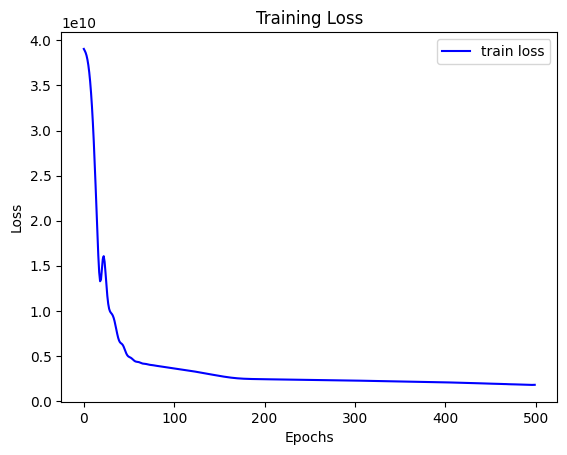

In [42]:
# 绘制训练损失曲线
plt.plot(range(num_epochs), train_losses, 'b-', label='train loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
# 预测结果
y_pred = model(test_features)
test_pred = y_pred.detach().numpy()

# 生成submission文件
submission = pd.DataFrame({'Id': test['Id'], 'SalePrice': test_pred.squeeze()})
submission.to_csv('submission_MLP_611.csv', index=False)